In [96]:
import sklearn.metrics

"""
Description: This program uses artificial recurrent neural network called Long Short Term Memory
             (LSTM) to predict the closing stock price of a selected corporation using the
             past 60 day stock price.
"""

#Import the libraries
import math
import pandas_datareader as web
import numpy as np
import pandas as pd
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_percentage_error
from keras.models import Sequential
from keras.layers import Dense, LSTM
import matplotlib.pyplot as plt
import plotly.graph_objs as go
import plotly.express as px

plt.style.use('fivethirtyeight')

In [97]:
# Get the stock quote
df = web.DataReader('BA',data_source='yahoo',start = '2015-12-29',end='2021-12-29')
# Show the data
df

,High,Low,Open,Close,Volume,Adj Close
Date,,,,,,
2015-12-29,147.559998,145.000000,145.059998,147.350006,3133600.0,132.148438
2015-12-30,148.000000,146.009995,147.220001,146.410004,1619000.0,131.305374
2015-12-31,145.960007,144.500000,145.960007,144.589996,2105200.0,129.673157
2016-01-04,141.699997,139.429993,141.380005,140.500000,5719500.0,126.005089
2016-01-05,141.699997,139.770004,140.990005,141.070007,3357000.0,126.516281
...,...,...,...,...,...,...
2021-12-22,202.929993,197.940002,199.460007,201.690002,8145300.0,201.690002
2021-12-23,205.130005,201.320007,202.130005,204.220001,7405500.0,204.220001
2021-12-27,203.429993,199.100006,201.990005,203.169998,7818900.0,203.169998


In [98]:
# Get the number of rows and columns in the data set
df.shape

(1512, 6)

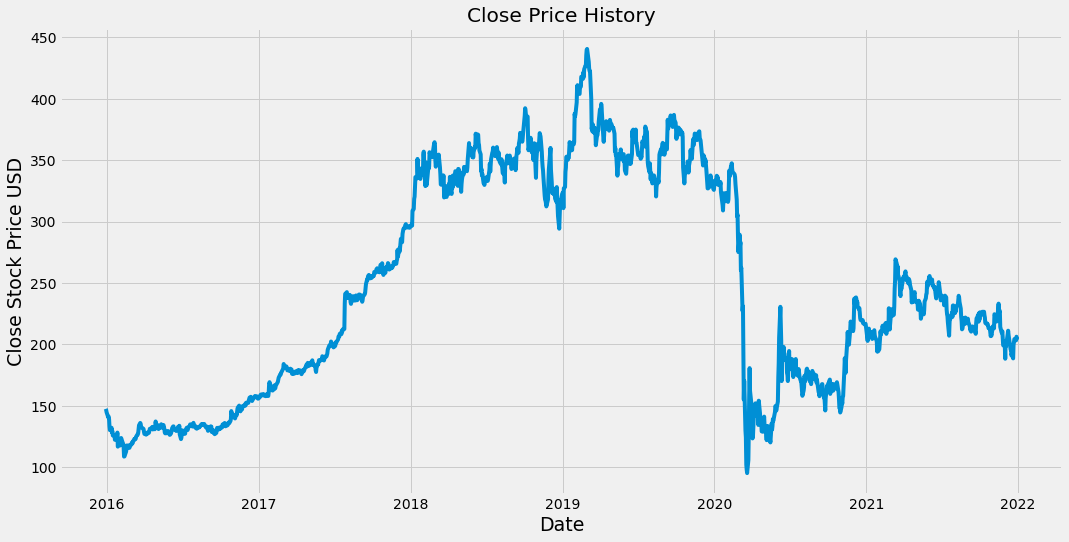

In [99]:
#Visualise the closing price history
# size of the graph
plt.figure(figsize=(16,8))
# Name of the graph
plt.title('Close Price History')
# Plot using 'Close' values
plt.plot(df['Close'])
# X-axis label and font size
plt.xlabel('Date',fontsize =19)
# Y-axis label and fot size
plt.ylabel('Close Stock Price USD',fontsize=19)

# display graph
plt.show()


#fig = px.line(df,y="Close",title="Learning and Testing Moddel")

#fig.show()


In [100]:
# Create a new dataframe with only the 'Close' column
data = df.filter(['Close'])
# Conver the dataframe to a numpy array
dataset = data.values
#Get the number of rows to train the model on (80%)
training_data_length = math.ceil(len(dataset) *0.90)

training_data_length

1361

In [101]:
# Scale the data (Normalise Data) - This creates new values that maintain the general distribution
# and ratios of the source data, while keeping values within a scale applied across all numeric
# columns used in the model.

# set the scaler to scale values between 0 and 1
scaler = MinMaxScaler(feature_range=(0,1))
# scale stock closing price into the values between 0 and 1
scaler_data = scaler.fit_transform(dataset)

scaler_data


array([[0.15144239],
       [0.14872256],
       [0.14345648],
       ...,
       [0.3129539 ],
       [0.32151849],
       [0.3143717 ]])

In [102]:
# Create the training data set
# Create the scaled training data set
# training data: from start of data to training_data_length
train_data = scaler_data[0:training_data_length, :]

# Split the data into x_train and y_train data sets
# independent training variables
x_train = []
# dependent training variables
y_train = []

# train data using 60 data values (60 day closing price)
# The model uses past 60 data values(x_train) to predict each y_train value
# So if i= 100, the model will use values between i-60 to i to predict next closing price value
for i in range(30,len(train_data)):
    # Append past 60 values to the x_train data set, it contains values from i =0 to i = 59
    x_train.append(train_data[i-30:i,0])
    # this data set contains 61th or i=60 value that we want the model to predict
    y_train.append(train_data[i,0])
    # print data just to check the values
    if i <= 30:
        print(x_train)
        print(y_train)
        print()

[array([0.15144239, 0.14872256, 0.14345648, 0.13162235, 0.13327162,
       0.12679031, 0.1099505 , 0.10121236, 0.10184892, 0.10679667,
       0.09580161, 0.09892652, 0.08859696, 0.08984114, 0.07849888,
       0.08214461, 0.08564567, 0.08390961, 0.09548333, 0.06241139,
       0.066549  , 0.07268307, 0.07682068, 0.0651312 , 0.07771766,
       0.08275223, 0.07971412, 0.07077341, 0.06906628, 0.06177483])]
[0.038858830988477144]



In [103]:
# Convert the x_train and y_train to numpy arrays
x_train,y_train = np.array(x_train), np.array(y_train)

In [104]:
#Reshape the data: Since LSTM expects 3d data model set (currently we have 2d: x_train and y_train)
# The LSTM expected input is: number of samples, number of steps and number of features
# x_train.shape[0] - number of data rows(samples)
# x_train.shape[1] - number of columns( number of steps) i.e last 60 days used to predict next day price
# number of features = 1 since we want only one predicted price

x_train = np.reshape(x_train,(x_train.shape[0],x_train.shape[1],1))
x_train.shape


(1331, 30, 1)

In [105]:
#Build the LSTM model
model = Sequential()
# Add layer to the model
# give LSTM 50 neurons, return sequence as true since another LSTM layer will be used on that sequence
# also since this is a first layer its shape needs to be defined (steps = x_train.shape[1] (60)
# and the number of features (price) equal to 1
model.add(LSTM(100,return_sequences=True,input_shape=(x_train.shape[1],1)))
# Add another LSTM layer
model.add(LSTM(50,return_sequences=False))
model.add(Dense(10))
model.add(Dense(1))

In [106]:
# Compile the model
#optimizer: an algorithm/method used to minimize an error functions or to maximize the efficiency of training
#           Main goal is to improve upon the loss function.
# loss function is used to measure how well the model did on training
model.compile(optimizer='adam',loss='mean_squared_error')


In [107]:
# Train the model
# The batch size is a number of samples processed before the model is updated
# epoch - the number of epochs is the number of complete passes through the training dataset
model.fit(x_train,y_train,batch_size=16,epochs=32,validation_split=0.15)

Epoch 1/32
71/71 [==============================] - 3s 19ms/step - loss: 0.0120 - val_loss: 0.0014

In [108]:
#Create the testing data set
# Create a new array containing scaled values from index
# from training data - 60 (60 values) to end of data set (empty - default)
# and get back all columns (empty - default)
test_data = scaler_data[training_data_length-30: , :]
#Create the data sets x_test and y_test
x_test = []
# basically it will contain all the values that the model will predict ( first 60 values - not scaled)
y_test = dataset[training_data_length: , :]

for i in range(30,len(test_data)):
    # append past 60 values
    x_test.append(test_data[i-30:i,0])


In [109]:
#Convert the data to a numpy array
x_test = np.array(x_test)


In [110]:
#Reshape the data
x_test = np.reshape(x_test,(x_test.shape[0],x_test.shape[1],1))
print(len(x_test))

151


In [111]:
#Get the models predicted price values, we want predictions to have the same values as y_data set
# as this would mean that the predictions are accurate
predictions = model.predict(x_test)
# unscale the values
predictions = scaler.inverse_transform(predictions )

In [112]:
# Get the root mean squared error (RMSE)
# RMSE is a good measure of how accurate the model predicts the responce, it is a standard
# deviation of the residues and the lower the RMSE value the mode accurate the model is
# check for rmse formula
rmse = np.sqrt(np.mean(predictions - y_test)**2)
rmse

0.6380238311969681

In [113]:
mape = mean_absolute_percentage_error(y_test,predictions)
mape

0.01653823242376632

C:\Users\baskr\AppData\Local\Temp/ipykernel_8784/1571797531.py:7: SettingWithCopyWarning:


A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy



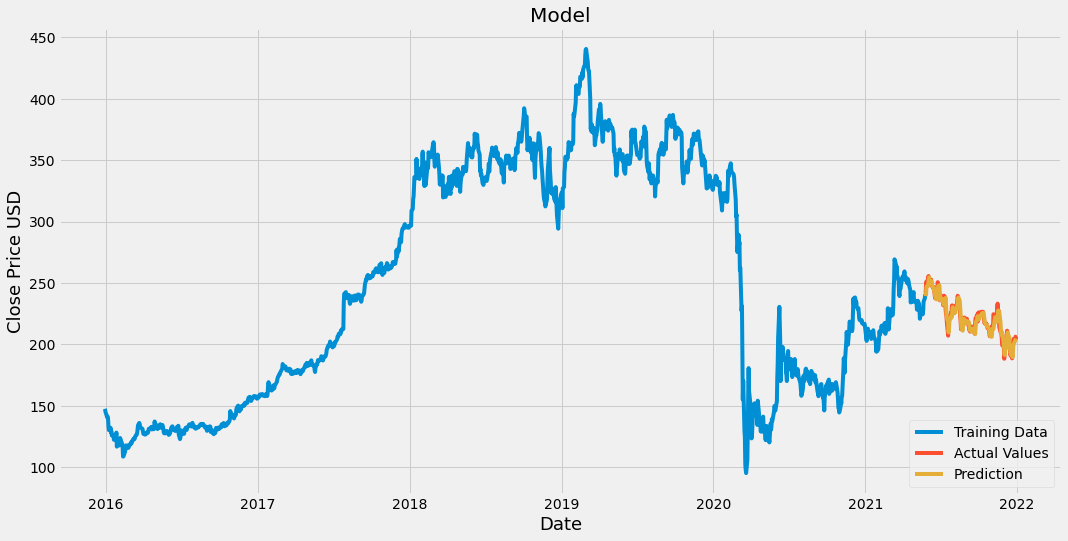

In [114]:
# Plot the data
# training data set
train = data[0:training_data_length]
# validation data set
valid = data[training_data_length:]
# assign predicted data
valid['Predictions'] = predictions

# Visualise the data
plt.figure(figsize=(16,8))
plt.title('Model')
plt.xlabel("Date",fontsize=18)
plt.ylabel("Close Price USD",fontsize=18)
plt.plot(train['Close'])
plt.plot(valid[['Close','Predictions']])
plt.legend(['Training Data','Actual Values','Prediction'],loc='lower right')
plt.show()

trainingSet =  go.Scatter(
                x=train.index,
                y=train['Close'],
                mode='lines',
                connectgaps=True,
                name = "Training Data"
)
validationSet =  go.Scatter(
                x=valid.index,
                y=valid['Close'],
                mode='lines',
                connectgaps=True,
                name = "Actual Values"
)
testingSet =  go.Scatter(
                x=valid.index,
                y=valid['Predictions'],
                mode='lines',
                connectgaps=True,
                name = "Predicted Values"
)

graphLayout = go.Layout(
    title = "Model",
    xaxis = {'title' : "Date"},
    yaxis = {'title' : "Close"},
    autosize= False,
    width=900,
    height=600
)
fig2= go.Figure(data=[trainingSet,testingSet,validationSet],layout=graphLayout)

fig2.show()

In [115]:
# Show the valid and predicted prices
valid


,Close,Predictions
Date,,
2021-05-26,241.369995,239.161880
2021-05-27,250.699997,240.751190
2021-05-28,247.020004,246.992157
2021-06-01,254.729996,247.521362
2021-06-02,255.619995,251.864990
...,...,...
2021-12-22,201.690002,194.562454
2021-12-23,204.220001,199.365738
2021-12-27,203.169998,202.877396


In [116]:
# Predict the future closing price
#Get the quote
apple_quote = web.DataReader('BA',data_source='yahoo',start='2015-12-29',end='2021-12-29')
# Create a new dataframe
new_df = apple_quote.filter(['Close'])
#Get the last 60 day closing price values and convert the dataframe to an array
last_60_days = new_df[-30:].values
# Scale the data to be values between 0 and 1
last_60_days_scaled = scaler.transform(last_60_days)
#Create an empty list
X_test = []
# Append the past 60 days
X_test.append(last_60_days_scaled)
#Convert x_test data set to a numpy array
X_test = np.array(X_test)
# Reshape the data
X_test = np.reshape(X_test,(X_test.shape[0],X_test.shape[1],1))
# Get the predicted scaled price
pred_price = model.predict(X_test)
# Undo the scaling
pred_price = scaler.inverse_transform(pred_price)
print(pred_price)

[[203.80188]]
